In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
ROOT_DIR = '/content/gdrive/MyDrive/emotion_recognition'

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [4]:
dataset_path = "/content/gdrive/MyDrive/emotion_recognition"  # Replace with the path to your dataset folder
batch_size = 32
image_size = (224, 224)
emotion_labels = ["angry","disgust","fear","happy","neutral","sad","surprise"]

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=30,        # Randomly rotate images
    width_shift_range=0.2,    # Shift images horizontally
    height_shift_range=0.2,   # Shift images vertically
    shear_range=0.2,          # Apply shear transformations
    zoom_range=0.2,           # Randomly zoom images
    horizontal_flip=True,     # Flip images horizontally
    fill_mode="nearest",      # Fill missing pixels after transformation
    validation_split=0.2      # Split data into training and validation
)

In [6]:
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

Found 91 images belonging to 7 classes.


In [7]:
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=True
)

Found 21 images belonging to 7 classes.


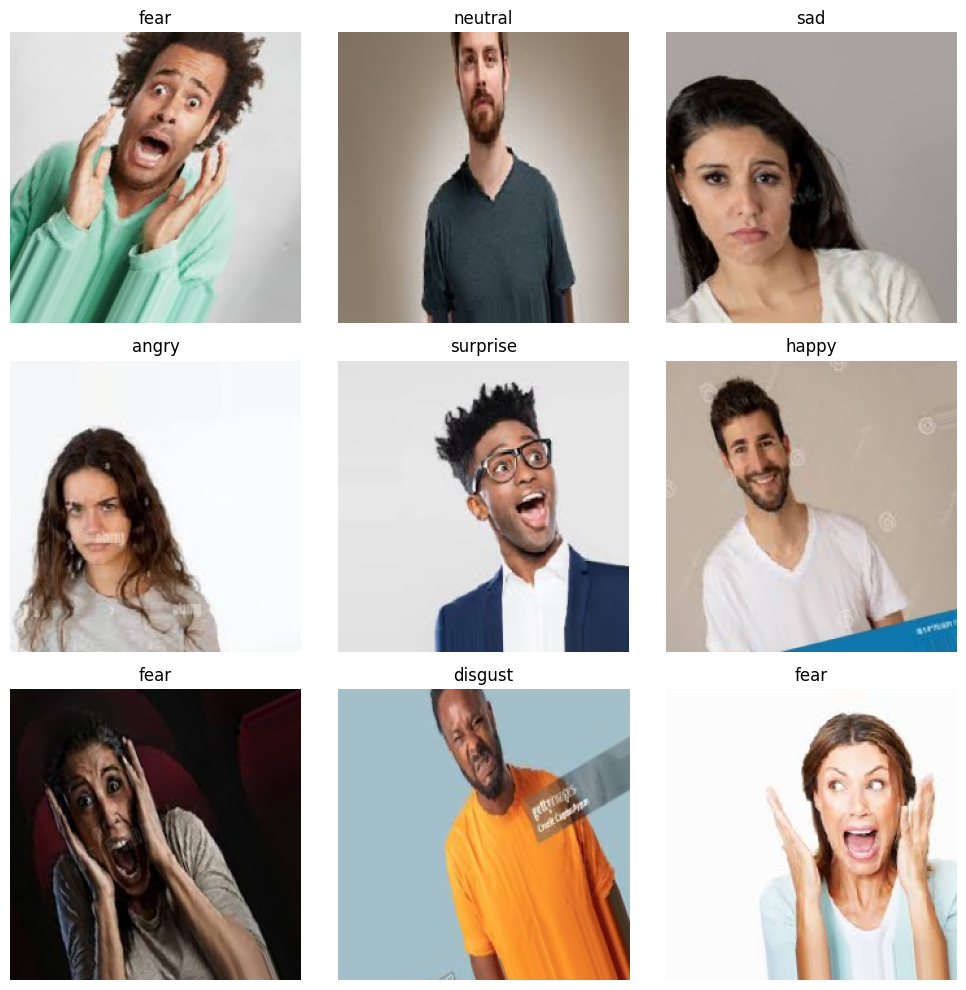

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display a grid of sample images with labels
def plot_sample_images(generator, class_labels, num_images=9):
    # Get a batch of images and labels from the generator
    images, labels = next(generator)

    # Create a figure with a grid layout
    plt.figure(figsize=(10, 10))

    for i in range(num_images):
        # Get the image and corresponding label
        image = images[i]
        label_index = np.argmax(labels[i])  # Get the label index
        label = class_labels[label_index]  # Map index to emotion label

        # Plot the image
        plt.subplot(3, 3, i + 1)  # Create a 3x3 grid
        plt.imshow(image)
        plt.title(label)  # Display the label as the title
        plt.axis("off")  # Turn off axis for better visualization

    plt.tight_layout()  # Adjust spacing
    plt.show()

# Display 9 sample images with their labels
plot_sample_images(train_generator, emotion_labels, num_images=9)


In [9]:
base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
for layer in base_model.layers:
    layer.trainable = False

In [11]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(len(emotion_labels), activation="softmax")(x)


In [12]:
model = Model(inputs=base_model.input, outputs=x)

In [13]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [14]:
epochs = 100  # You can increase this based on your dataset size
emotion_recognition = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 11s/step - accuracy: 0.1021 - loss: 4.9293 - val_accuracy: 0.0476 - val_loss: 4.4842
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.1699 - loss: 4.7057 - val_accuracy: 0.0476 - val_loss: 4.1787
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 620ms/step - accuracy: 0.2248 - loss: 4.2012 - val_accuracy: 0.1905 - val_loss: 4.0606
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 591ms/step - accuracy: 0.3875 - loss: 3.8498 - val_accuracy: 0.3810 - val_loss: 3.8790
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 656ms/step - accuracy: 0.2287 - loss: 3.8350 - val_accuracy: 0.3333 - val_loss: 3.8495
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 653ms/step - accuracy: 0.3642 - loss: 3.6361 - val_accuracy: 0.2381 - val_loss: 3.6698
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 611ms/step - accuracy: 0.3550 - loss: 3.5920 - val_accuracy: 0.5714 - val_loss: 3.4548
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 638ms/step - accuracy: 0.4093 - loss: 3.3939 - val_accuracy: 0.3333 - val_

In [15]:
model.save("emotion_recognition_model.keras")
print("Model saved successfully!")

Model saved successfully!


In [16]:
loaded_model = tf.keras.models.load_model("emotion_recognition_model.keras")

In [17]:
def recognize_emotion_and_highlight(image_path, model, labels):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    original_image = image.copy()
    image_resized = cv2.resize(image, (224, 224))
    image_array = np.expand_dims(image_resized, axis=0) / 255.0  # Normalize the image

    # Predict the emotion
    predictions = model.predict(image_array)
    emotion_index = np.argmax(predictions)
    emotion_label = labels[emotion_index]
    confidence = predictions[0][emotion_index] * 100

    # Display the emotion on the image
    text = f"{emotion_label}: {confidence:.2f}%"
    cv2.putText(original_image, text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2_imshow(original_image)  # Use cv2.imshow if not in Colab
    return emotion_label

In [18]:
import tensorflow as tf
import numpy as np
import cv2
from datetime import datetime
import csv
from google.colab.patches import cv2_imshow  # For displaying images in Colab

# Function to log emotion detection
def log_detection(log_file, image_path, emotion, confidence):
    """
    Logs the details of each emotion detection to a CSV file.
    Args:
        log_file (str): Path to the log file.
        image_path (str): Path to the input image.
        emotion (str): Detected emotion.
        confidence (float): Confidence score of the detection.
    """
    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Append the log details to the CSV file
    with open(log_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([timestamp, image_path, emotion, f"{confidence:.2f}%"])
    print(f"Logged detection: {timestamp}, {emotion}, {confidence:.2f}%")

# Function to recognize emotion and highlight it on the image
def recognize_emotion_and_highlight(image_path, model, labels, log_file="detection_log.csv"):
    """
    Recognizes the emotion in an image and highlights it with the label.
    Logs the detection result in a file.
    Args:
        image_path (str): Path to the input image.
        model (tf.keras.Model): Trained emotion recognition model.
        labels (list): List of emotion labels.
        log_file (str): Path to the log file.
    """
    # Load and preprocess the image
    image = cv2.imread(image_path)
    original_image = image.copy()
    image_resized = cv2.resize(image, (224, 224))
    image_array = np.expand_dims(image_resized, axis=0) / 255.0  # Normalize the image

    # Predict the emotion
    predictions = model.predict(image_array)
    emotion_index = np.argmax(predictions)
    emotion_label = labels[emotion_index]
    confidence = predictions[0][emotion_index] * 100

    # Display the emotion on the image
    text = f"{emotion_label}: {confidence:.2f}%"
    cv2.putText(original_image, text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2_imshow(original_image)  # Use cv2.imshow if not in Colab

    # Log the detection
    log_detection(log_file, image_path, emotion_label, confidence)

    return emotion_label

# Initialize log file with headers (if not already present)
log_file = "detection_log.csv"
with open(log_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Timestamp", "Image Path", "Detected Emotion", "Confidence"])
print(f"Log file initialized: {log_file}")

# Example: Test the function with a sample image


Log file initialized: detection_log.csv


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


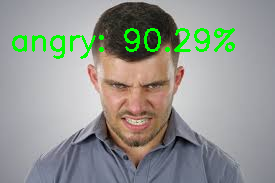

Logged detection: 2025-02-23 09:24:01, angry, 90.29%
Recognized Emotion: angry


In [19]:
test_image_path = "/content/gdrive/MyDrive/emotion_recognition/angry/download (2).jpg"  # Replace with the path to your test image
emotion_labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
model = tf.keras.models.load_model("emotion_recognition_model.keras")  # Load your trained model
recognized_emotion = recognize_emotion_and_highlight(test_image_path, model, emotion_labels, log_file)

print(f"Recognized Emotion: {recognized_emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


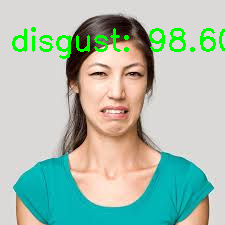

Logged detection: 2025-02-23 09:25:10, disgust, 98.60%
Recognized Emotion: disgust


In [20]:
test_image_path = "/content/gdrive/MyDrive/emotion_recognition/disgust/download (3).jpg"  # Replace with the path to your test image
emotion_labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
model = tf.keras.models.load_model("emotion_recognition_model.keras")  # Load your trained model
recognized_emotion = recognize_emotion_and_highlight(test_image_path, model, emotion_labels, log_file)

print(f"Recognized Emotion: {recognized_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


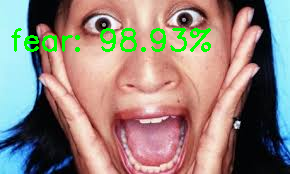

Logged detection: 2025-02-23 09:25:24, fear, 98.93%
Recognized Emotion: fear


In [21]:
test_image_path = "/content/gdrive/MyDrive/emotion_recognition/fear/download (6).jpg"  # Replace with the path to your test image
emotion_labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
model = tf.keras.models.load_model("emotion_recognition_model.keras")  # Load your trained model
recognized_emotion = recognize_emotion_and_highlight(test_image_path, loaded_model, emotion_labels)
print(f"Recognized Emotion: {recognized_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


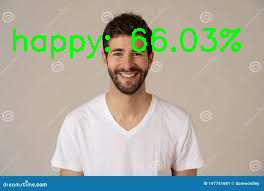

Logged detection: 2025-02-23 09:25:36, happy, 66.03%
Recognized Emotion: happy


In [22]:
test_image_path = "/content/gdrive/MyDrive/emotion_recognition/happy/download (5).jpg"  # Replace with the path to your test image
emotion_labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
model = tf.keras.models.load_model("emotion_recognition_model.keras")  # Load your trained model
recognized_emotion = recognize_emotion_and_highlight(test_image_path, loaded_model, emotion_labels)
print(f"Recognized Emotion: {recognized_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


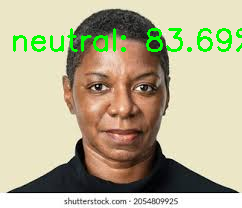

Logged detection: 2025-02-23 09:25:45, neutral, 83.69%
Recognized Emotion: neutral


In [23]:
test_image_path = "/content/gdrive/MyDrive/emotion_recognition/neutral/download (2).jpg"  # Replace with the path to your test image
emotion_labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
model = tf.keras.models.load_model("emotion_recognition_model.keras")  # Load your trained model
recognized_emotion = recognize_emotion_and_highlight(test_image_path, loaded_model, emotion_labels)
print(f"Recognized Emotion: {recognized_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


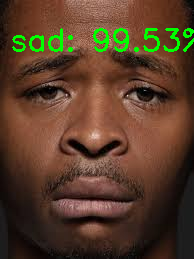

Logged detection: 2025-02-23 09:25:56, sad, 99.53%
Recognized Emotion: sad


In [24]:
test_image_path = "/content/gdrive/MyDrive/emotion_recognition/sad/download (5).jpg"  # Replace with the path to your test image
emotion_labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
model = tf.keras.models.load_model("emotion_recognition_model.keras")  # Load your trained model
recognized_emotion = recognize_emotion_and_highlight(test_image_path, loaded_model, emotion_labels)
print(f"Recognized Emotion: {recognized_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


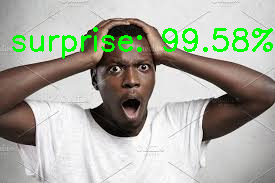

Logged detection: 2025-02-23 09:26:07, surprise, 99.58%
Recognized Emotion: surprise


In [25]:
test_image_path = "/content/gdrive/MyDrive/emotion_recognition/surprise/download (6).jpg"  # Replace with the path to your test image
emotion_labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
model = tf.keras.models.load_model("emotion_recognition_model.keras")  # Load your trained model
recognized_emotion = recognize_emotion_and_highlight(test_image_path, loaded_model, emotion_labels)
print(f"Recognized Emotion: {recognized_emotion}")

In [ ]:
test_image_path = "/content/Screenshot 2025-01-28 155911.png"  # Replace with the path to your test image
emotion_labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
model = tf.keras.models.load_model("emotion_recognition_model.keras")  # Load your trained model
recognized_emotion = recognize_emotion_and_highlight(test_image_path, loaded_model, emotion_labels)
print(f"Recognized Emotion: {recognized_emotion}")

In [26]:
# Evaluate the model on training and validation datasets
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=1)

# Print accuracy results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 808ms/step - accuracy: 1.0000 - loss: 0.6069
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3810 - loss: 2.0937
Training Accuracy: 100.00%
Validation Accuracy: 38.10%


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    "/content/gdrive/MyDrive/emotion_recognition",  # Replace with your test dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Evaluate the model on test data
loss, accuracy = model.evaluate(test_generator, verbose=1)

print(f"Test Accuracy: {accuracy * 100:.2f}%")


Found 112 images belonging to 7 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9195 - loss: 0.7870
Test Accuracy: 91.07%


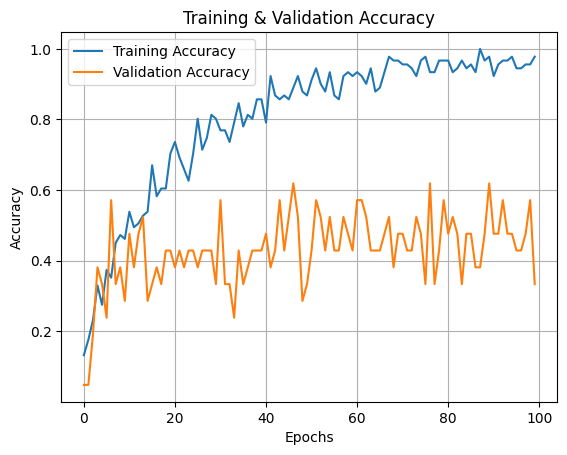

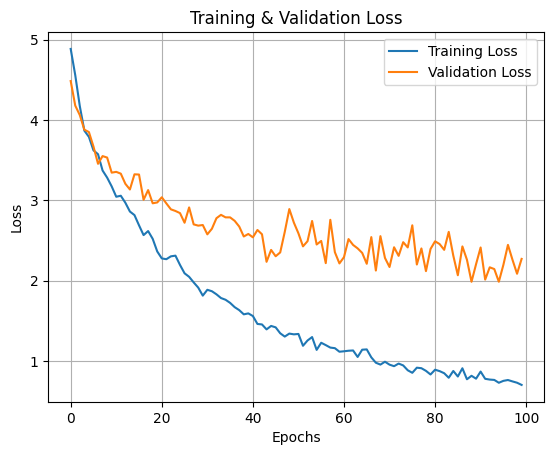

In [28]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.plot(emotion_recognition.history['accuracy'], label='Training Accuracy')
plt.plot(emotion_recognition.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training & Validation Loss
plt.plot(emotion_recognition.history['loss'], label='Training Loss')
plt.plot(emotion_recognition.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Clear the accuracy log file
with open("detection_log.csv", "w") as log_file:
    log_file.write("")  # Writing an empty string clears the file

print("Log file cleared successfully.")
